In [1]:
from orphics import sehgal
import numpy as np
import os
import matplotlib.pyplot as plt
from pixell import enmap, curvedsky, utils, enplot
import healpy as hp

%matplotlib inline
%load_ext autoreload
%autoreload 2

kappa


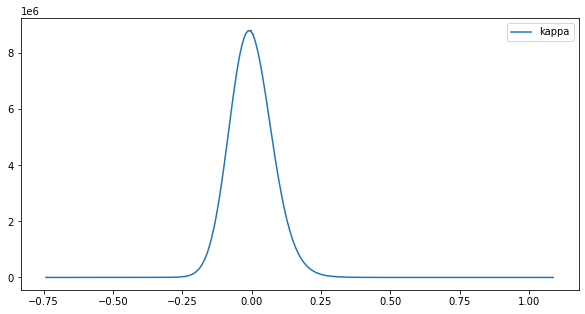

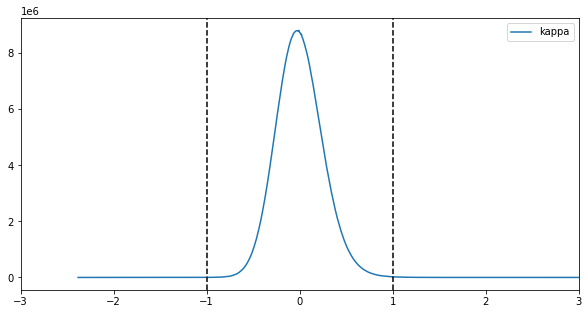

ir_pts


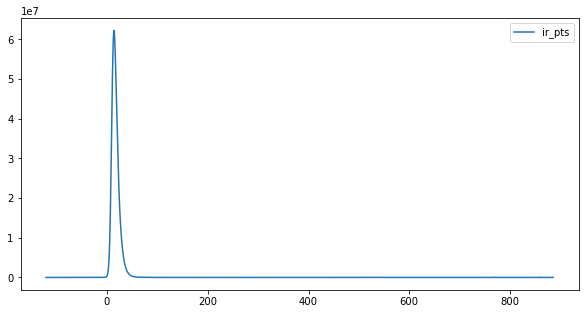

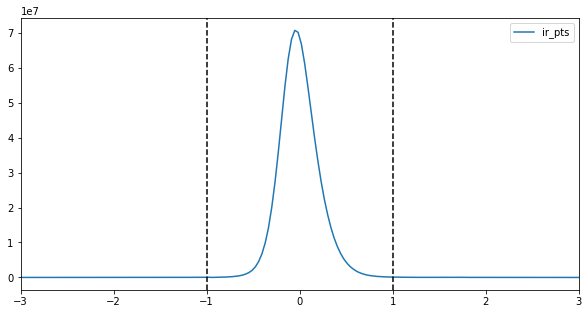

ksz


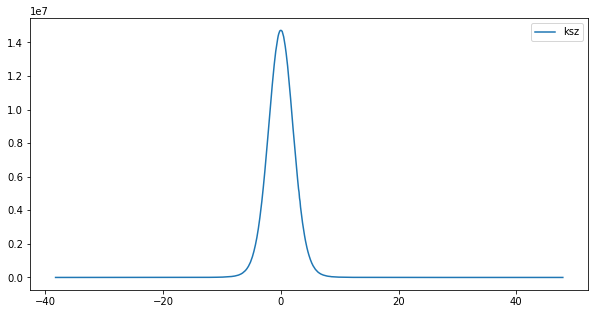

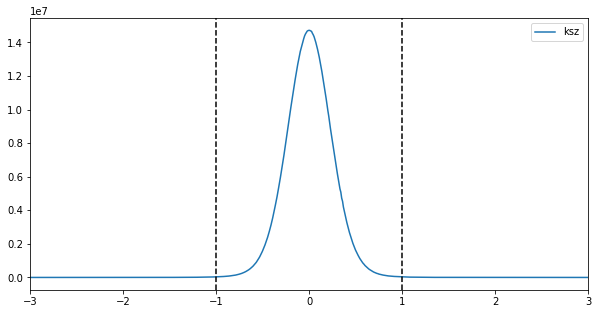

rad_pts


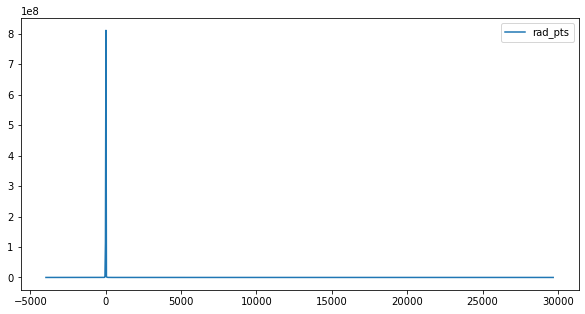

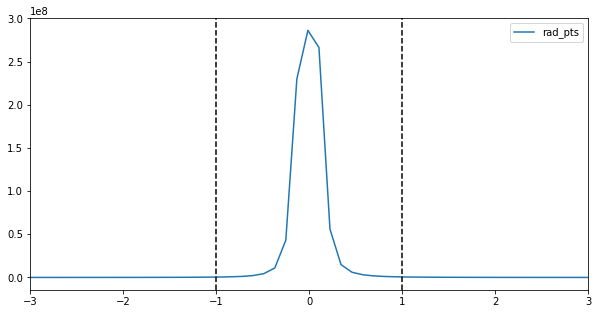

tsz


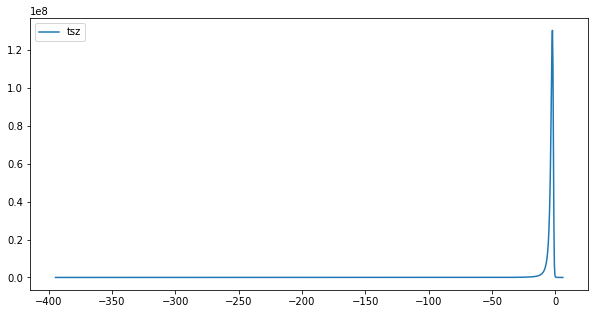

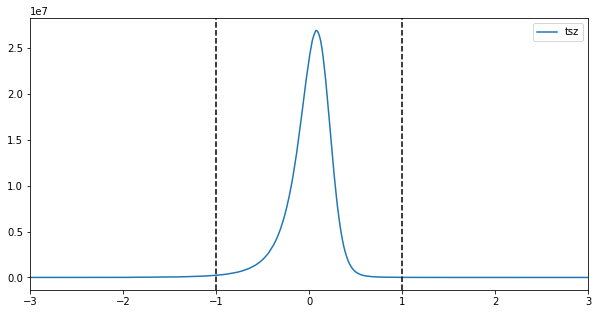

In [2]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
SEHGAL10 = sehgal.SehgalSky2010(path=sehgal_dir, data_type='enmap')

hists_org = {}
hists_norm = {}
norm_info = {}
zfact = 4

def power_normalize(emap, pos_pow, neg_pow):
    temp = emap.copy()
    loc = np.where(emap>=0)
    temp[loc] = temp[loc]**pos_pow
    loc = np.where(emap<0)
    temp[loc] = -1*np.abs(temp[loc])**neg_pow
    return temp

def mean_normalize(emap):
    temp = emap.copy()
    temp = temp - np.mean(temp)
    return temp

def minmax_normalize(emap):
    max_val, min_val = emap.max(), emap.min()
    return (emap)/(max_val-min_val)

def z_normalize(emap, zfact = zfact):
    mean, std = emap.mean(), emap.std()
    
    return (emap-mean)/(std*zfact), (mean, std)

rfs = {"kappa": SEHGAL10.get_kappa,
       "ksz": SEHGAL10.get_ksz,
       "tsz": SEHGAL10.get_tsz,
       "rad_pts": SEHGAL10.get_radio,
       "ir_pts": SEHGAL10.get_cib
      }

freq_idx = 148
ns = {"kappa": z_normalize,
      "ksz": z_normalize,
      "ir_pts": lambda x: z_normalize(power_normalize(x, 1/2, 1)),
      "rad_pts": lambda x: z_normalize(power_normalize(x, 0.7, 0.7)),
      "tsz": lambda x: z_normalize(power_normalize(x, 1, 1/4)),
     }

for compt_idx in ['kappa']:
    print(compt_idx)
    emap = rfs[compt_idx]()

    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_org[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.legend()
    plt.show()
    
    emap, norm_info[compt_idx] = ns[compt_idx](emap)
    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_norm[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.legend()
    plt.xlim(-3,3)
    plt.show()

for compt_idx in ['ir_pts', "ksz", "rad_pts", "tsz"]:
    print(compt_idx)
    emap = rfs[compt_idx](freq_idx)#

    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_org[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist, label=compt_idx)
    plt.legend()
    plt.show()
    
    emap, norm_info[compt_idx] = ns[compt_idx](emap)
    hist, bins = np.histogram(emap.flatten(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hists_norm[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.xlim(-3,3)
    plt.plot(bin_center, hist, label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.legend()
    plt.show()



In [18]:
 hists_norm

{'kappa': (array([1, 0, 0, ..., 1, 0, 1]),
  array([-2.3844579 , -2.37871114, -2.37296439, ...,  3.48872527,
          3.49447203,  3.50021878])),
 'ir_pts': (array([8, 0, 0, ..., 0, 0, 8]),
  array([-30.08481336, -30.04941765, -30.01402194, ...,   6.08960553,
           6.12500125,   6.16039696])),
 'ksz': (array([ 8,  8,  8, ...,  0,  0, 16]),
  array([-4.21582273, -4.20655346, -4.19728419, ...,  5.25737149,
          5.26664077,  5.27591004])),
 'rad_pts': (array([48, 24,  8, ...,  0,  0,  8]),
  array([-23.93322489, -23.81451929, -23.69581368, ...,  97.38390485,
          97.50261046,  97.62131606])),
 'tsz': (array([16,  8,  8, ...,  0,  0,  8]),
  array([-3.91824009, -3.90526142, -3.89228274, ...,  9.34596504,
          9.35894371,  9.37192239]))}

In [24]:
norm_info_out = {} 
pows_facts = {"kappa": (1.,1.),
      "ksz": (1.,1.),
      "ir_pts": (1., 0.5),
      "rad_pts": (0.7, 0.7),
      "tsz": (0.25, 1.)
     }

for idx in norm_info.keys():
    norm_info_out[idx] = {"mean":float(norm_info[idx][0]), "std":float(norm_info[idx][1]),
                          "pow_neg": pows_facts[idx][0], "pow_pos": pows_facts[idx][1]}
    
hist_org_out = {} 
for idx in hists_org.keys():
    hist_org_out[idx] = {}
    hist_org_out[idx]["hist"] = hists_org[idx][0]
    bin_edges =  hists_org[idx][1]
    hist_org_out[idx]["bin_centers"] = (bin_edges[:-1]+bin_edges[1:])/2.
    hist_org_out[idx]["bin_edges"] = bin_edges
    
hist_norm_out = {} 
for idx in hists_norm.keys():
    hist_norm_out[idx] = {}
    hist_norm_out[idx]["hist"] = hists_norm[idx][0]
    bin_edges =  hists_norm[idx][1]
    hist_norm_out[idx]["bin_centers"] = (bin_edges[:-1]+bin_edges[1:])/2.
    hist_norm_out[idx]["bin_edges"] = bin_edges

In [25]:
data_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def data_path(x):
    return os.path.join(data_dir, x)

def load_data(data_path):
    data = np.load(data_path, allow_pickle=True)    
    return {key:data[key].item() for key in data}

np.savez(data_path("original_histogram_full.npz"), **hist_org_out)
np.savez(data_path("normalized_histogram_full.npz"), **hist_norm_out)
np.savez(data_path("normalization_info_full.npz"), **norm_info_out)




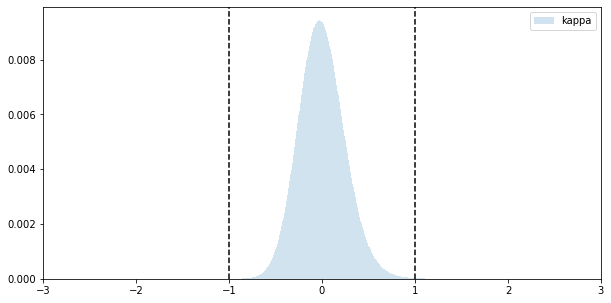

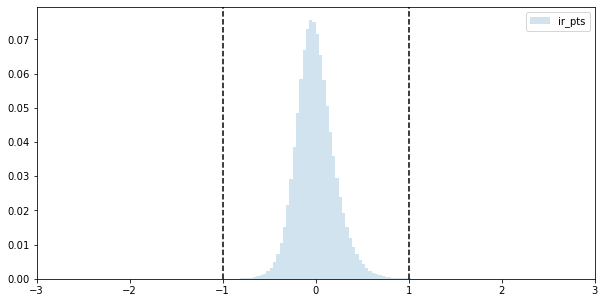

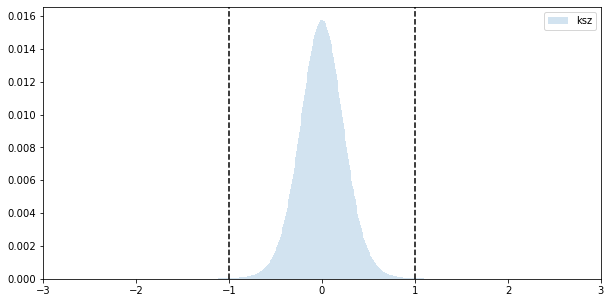

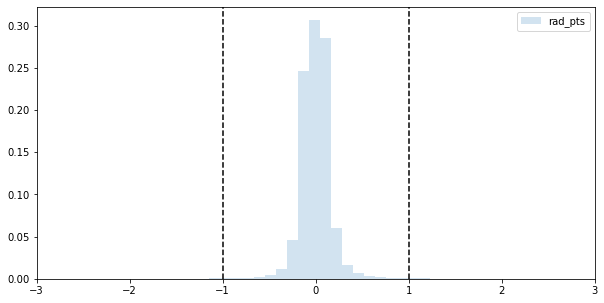

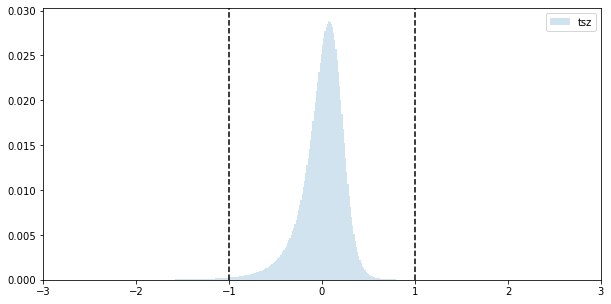

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

hists_org = load_data(data_path("original_histogram_full.npz"))
hists_norm = load_data(data_path("normalized_histogram_full.npz"))
norm_info = load_data(data_path("normalization_info_full.npz"))


for key in hists_norm.keys():
    fig = plt.figure(figsize=(10, 5))
    hist = hists_norm[key]["hist"]
    nsum = np.sum(hist)
    bins = hists_norm[key]["bin_edges"]
    bin_center = hists_norm[key]["bin_centers"]
    width = (bins[:-1]-bins[1:])[0]
    plt.bar(bin_center, hist/nsum, width, label=key, alpha=0.2)
    plt.xlim(-3,3)
    plt.legend()
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.show()
      

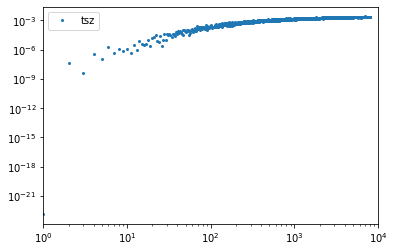

In [58]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
spec_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/specs"

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
template = enmap.zeros(shape, wcs)

fig = plt.figure()
freq_idx = 148
fgs = ["lensedcmb", "skymap"]
for fg_idx in fgs:
    alm_file = os.path.join(sehgal_dir, "148_%s_alm.fits"%fg_idx)
    enmap_file = os.path.join(sehgal_dir, "148_%s_enmap.fits"%fg_idx)
    spec_file = os.path.join(spec_dir, "148_%s_dls.npy"%fg_idx)
    alm = np.complex128(hp.read_alm(alm_file))
    fgmap = template.copy()
    fgmap = curvedsky.alm2map(alm, fgmap)
    cl = hp.alm2cl(alm)*sehgal.jysr2thermo(148)**2
    l = np.arange(len(cl))
    l_fact = l*(l+1)/(2*np.pi)
    plt.plot(l, l_fact*cl, label=fg_idx, ls="", marker="o"
            , markersize=2)
    specs = np.zeros((8000+1, 2))
    specs[:,0] = l
    specs[:,1] = l_fact*cl
    np.save(spec_file, specs)
    enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
#plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()

fig = plt.figure()
freq_idx = 148
fgs = ['ir_pts', "ksz", "rad_pts", "tsz", "lensed"]
for fg_idx in fgs:
    alm_file = os.path.join(sehgal_dir, "148_%s_alm.fits"%fg_idx)
    enmap_file = os.path.join(sehgal_dir, "148_%s_enmap.fits"%fg_idx)
    spec_file = os.path.join(spec_dir, "148_%s_dls.npy"%fg_idx)
    alm = np.complex128(hp.read_alm(alm_file))
    fgmap = template.copy()
    fgmap = curvedsky.alm2map(alm, fgmap)
    cl = hp.alm2cl(alm)*sehgal.jysr2thermo(148)**2
    l = np.arange(len(cl))
    l_fact = l*(l+1)/(2*np.pi)
    plt.plot(l, l_fact*cl, label=fg_idx, ls="", marker="o"
            , markersize=2)
    specs = np.zeros((8000+1, 2))
    specs[:,0] = l
    specs[:,1] = l_fact*cl
    np.save(spec_file, specs)
    enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()

fig = plt.figure()

alm_file = os.path.join(sehgal_dir, "kappa_alm.fits")
enmap_file = os.path.join(sehgal_dir, "kappa_enmap.fits")
spec_file = os.path.join(spec_dir, "kappa_cls.npy")
alm = np.complex128(hp.read_alm(alm_file))
fgmap = template.copy()
fgmap = curvedsky.alm2map(alm, fgmap)
cl = hp.alm2cl(alm)
l = np.arange(len(cl))
plt.plot(l, l_fact*cl, label="kappa", ls="", marker="o"
        , markersize=2)
specs = np.zeros((8000+1, 2))
specs[:,0] = l
specs[:,1] = cl
np.save(spec_file, specs)
enmap.write_map(enmap_file, fgmap)
    
plt.legend()
plt.xlim(1, 1e4)
#plt.ylim(1e-2, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.show()